In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
tweets = pd.read_csv('Tweets.csv')
#tweets = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweets.shape

(14640, 15)

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
#Number of sentiments in each category

tweets.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

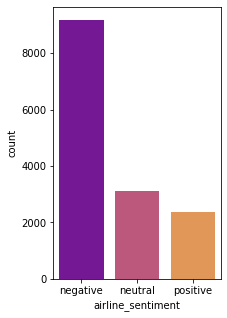

In [8]:
plt.figure(figsize=(3,5))
sns.countplot(tweets['airline_sentiment'], order =tweets.airline_sentiment.value_counts().index,palette= 'plasma')
plt.show()

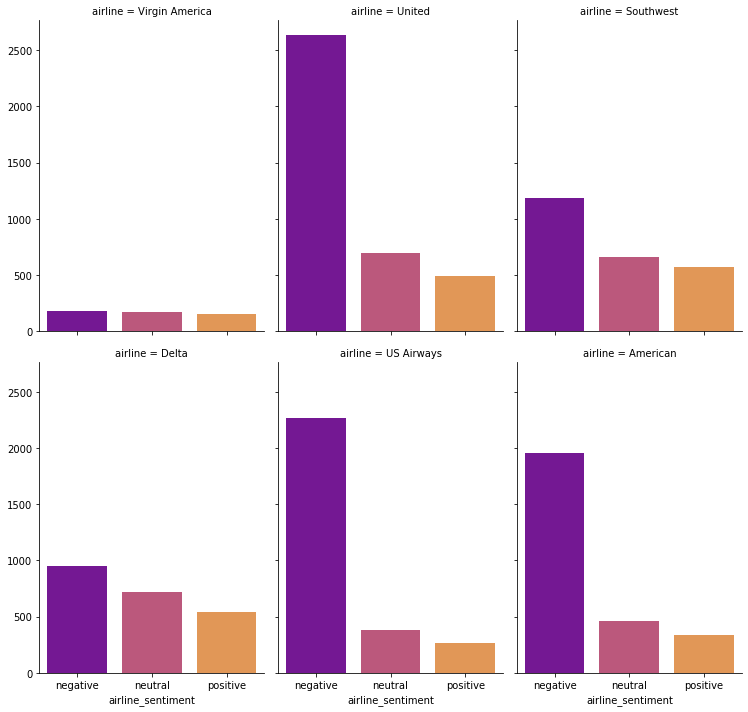

In [9]:
g = sns.FacetGrid(tweets, col="airline", col_wrap=3, height=5, aspect =0.7)
g = g.map(sns.countplot, "airline_sentiment",order =tweets.airline_sentiment.value_counts().index, palette='plasma')
plt.show()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline
from warnings import filterwarnings
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline


In [11]:
twitter_sentiment = Pipeline([('CVec', CountVectorizer(CountVectorizer(stop_words='english'))),
                     ('Tfidf', TfidfTransformer()),
                      ('norm', Normalizer()),
                    ('tSVD', TruncatedSVD(n_components=100)),
                     ('lgb', LGBMClassifier(n_jobs=-1))])


In [12]:
%%time
cv_pred = cross_validate(twitter_sentiment, 
                             tweets['text'], 
                             tweets['airline_sentiment'], 
                             cv=5,
                             scoring=('roc_auc_ovr'))

Wall time: 48 s


In [13]:
sorted(cv_pred.keys())

['fit_time', 'score_time', 'test_score']

In [14]:
cv_pred['test_score']

array([0.83545366, 0.84527766, 0.76826568, 0.84774811, 0.82988007])